# ACDS - The day after tomorrow
###### Team Katrina

In [1]:
import torch
import storm_forcast as sf
import pytorch_ssim
import numpy as np
import io
import imageio
import matplotlib.pyplot as plt
from IPython.core.display_functions import display
from ipywidgets import HBox, widgets

## Check GPU Status

In [2]:
!nvidia-smi

Fri May 27 18:46:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   51C    P8    17W / 240W |   1197MiB /  8192MiB |     26%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    device = 'cuda'
    print("Cuda installed! Running on GPU %s!" % torch.cuda.get_device_name())

else:
    print("No GPU available! Running on CPU")

Cuda installed! Running on GPU NVIDIA GeForce RTX 3070!
Cuda installed! Running on GPU NVIDIA GeForce RTX 3070!


## Install dependencies

In [4]:
!pip install radiant-mlhub==0.4.1 livelossplot pycm imageio

# Training model

In [5]:
! mkdir models

子目录或文件 models 已经存在。
子目录或文件 models 已经存在。


In [6]:
# Set training hyperparameters
config = dict(
    root_dir='~/Downloads/data',
    download=False,
    seq_size=20,
    storm_list=['acd'],
    batch_size=1,
    num_kernels=8,
    kernel_size=(3, 3),
    padding=(1, 1),
    frame_size=(366, 366),
    activation="relu",
    num_layers=3,
    lr=1e-4,
    epochs=20,
    surprise=False,
)

In [7]:
model_path = sf.train_model(config)

wandb: Currently logged in as: acse-bp221 (katrina-2022). Use `wandb login --relogin` to force relogin


Cuda installed! Running on GPU NVIDIA GeForce RTX 3070!


wandb: Currently logged in as: acse-bp221 (katrina-2022). Use `wandb login --relogin` to force relogin


Cuda installed! Running on GPU NVIDIA GeForce RTX 3070!


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_ssim,▁▅▆▇▇▇▇▇▇███████████
valid_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_ssim,▁▃▆▇▇▇██████████████
epoch,20
train_loss,0.00707
train_ssim,0.62693
valid_loss,0.00217
valid_ssim,0.7395


## Testing

##### Build an model

In [8]:
model = sf.Seq2Seq(num_channels=1, num_kernels=config['num_kernels'],
                kernel_size=config['kernel_size'], padding=config['padding'], activation=config['activation'],
                frame_size=config['frame_size'], num_layers=config['num_layers']).to(device)

In [9]:
model.load_state_dict(torch.load('./models/ConvLSTM_storm_8_20.pt'))
# model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

##### Load Data from test dataset

In [10]:
class DottableDict(dict):
    def __init__(self, *args, **kwargs):
        dict.__init__(self, *args, **kwargs)
        self.__dict__ = self

    def allow_dotting(self, state=True):
        if state:
            self.__dict__ = self
        else:
            self.__dict__ = dict()

config = DottableDict(config)

In [11]:
test_loader = sf.make_storm_dataloader(test=True, config=config)

##### Get a batch

In [12]:
batch, target = next(iter(test_loader))

##### Convert to ndarray

In [13]:
# target = target - target.mean() / target.std()
target = target.squeeze(1).cpu().numpy() * 255.0

##### Initialize output sequence

In [14]:
output = np.zeros(target.shape, dtype=np.float32)

##### Loop over timesteps and save the outputs

In [15]:
for timestep in range(target.shape[1]):
    # The input length is sequence length - 5
    input = batch[:, :, timestep:timestep + config.seq_size - 5]
    # calculate the prediction
    model_output = model(input)
    # standardize the output
    # model_output = model_output - model_output.mean() / model_output.std()
    # save the output into output sequence
    output[:, timestep] = (model_output.squeeze(1).detach().cpu().numpy())
    # Save the output to batch as input to the next prediction
    batch[:, :, timestep + config.seq_size - 5] = torch.tensor(output[:, timestep].squeeze(0))

In [16]:
# standardize the output
output = output * 255.0

##### Generated GIF
The real picture on the left and the forecast on the right

In [17]:
for tgt, out in zip(target, output):
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps=5)
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps=5)
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif),
                  widgets.Image(value=output_gif)]))

Lossy conversion from float32 to uint8. Range [1.0, 214.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.0, 217.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 198.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.0, 193.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.0, 198.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.060728962443136e-07, 246.39739990234375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00022283635917119682, 247.38600158691406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.6260275840759

##### Static comparison of running results
The real graph is at the top and the corresponding forecast graph is at the bottom

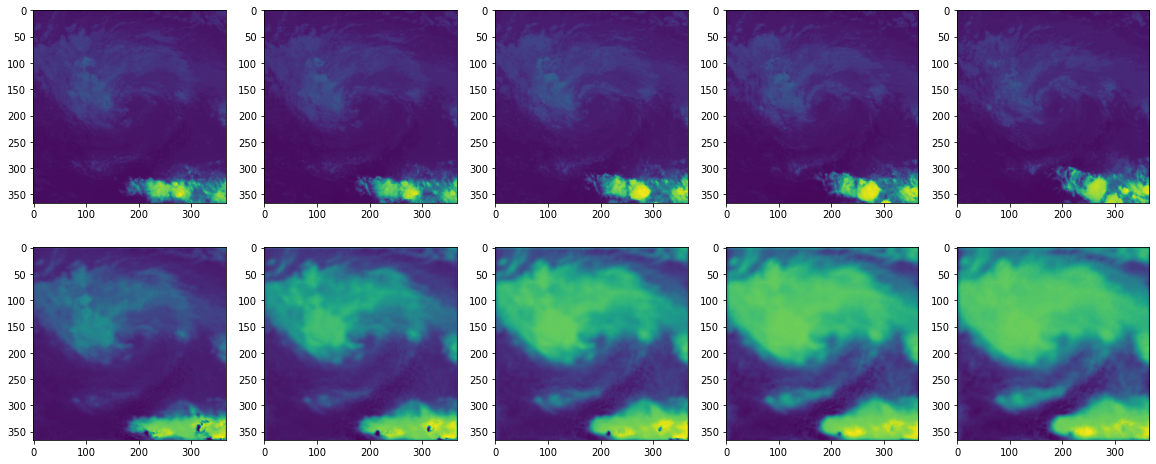

In [18]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for tgt, out in zip(target, output):
    for i in range(5):
        tgt_i, out_i = tgt[i], out[i]
        ax[0, i].imshow(tgt_i,cmap='viridis')
        ax[1, i].imshow(out_i,cmap='viridis')
        ax[0, i].grid(False)
        ax[1, i].grid(False)

##### Function From `nasa_tropical_storm_competition_surprise_storm_metrics.tar`

In [19]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import numpy as np

def scale2range(x, range):
    # Scale x into a range, both expected to be floats
    return (x - x.min()) * (max(range) - min(range)) / (x.max() - x.min()) + min(range)

##### Calculate the SSIM of each step

In [20]:
print("Step", "SSIM", "MSE")
for tgt, out in zip(target, output):
    for i in range(5):
        tgt_i, out_i = tgt[i], out[i]
        out_i = scale2range(out_i, [tgt_i.min(), tgt_i.max()])
        # Cast to uint8 to accommodate for consistent SSIM and MSE results
        tgt_i, out_i = tgt_i.astype(np.uint8), out_i.astype(np.uint8)
        # Compute metrics
        s, m = ssim(tgt_i, out_i), mse(tgt_i, out_i)
        print(i + 96, s, m)

Step SSIM MSE
96 0.7764548473785773 547.6316551703544
97 0.5459316076286871 2823.4344187643705
98 0.46032521376582064 4290.850473289737
99 0.40586801825765645 5533.916188897847
100 0.3672212952808596 6616.004531338648
